In [1]:
# Basic system and data packages
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

In [2]:
df = pd.read_csv('../../../data/emissions-projection/emissions-populations-dvmt.csv')
#Plot the data set
df

# Drop the first column
df = df.drop(columns=['Unnamed: 0'])

# Set the second column as the row index
df = df.set_index('Year')
df['Stationary combustion']=df['Commercial GHG Emissions (MMTCO2e)']+df['Industrial GHG Emissions (MMTCO2e)']+df['Residential GHG Emissions (MMTCO2e)']

In [3]:
#split into training data and test data
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()
df_test

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles),Stationary combustion
Year,,,,,,,,,,,
2016,15.214360,0.339883,3.907677,9.289161,3.152446,6.380817,1.950564,0.394595,3579830,86444182,13.440940
2017,15.325243,0.341291,3.920870,8.501146,3.123419,6.621179,1.868640,0.394567,3575324,86301543,13.665468
2018,15.633220,0.350344,4.329612,8.066976,3.137983,7.595505,1.766990,0.394951,3574561,86563582,15.063100
2019,15.399656,0.369979,4.196598,5.690000,3.146549,7.414013,1.860953,0.392797,3566022,86577672,14.757161
2020,13.071437,0.346028,3.824505,3.200000,3.128899,6.665511,1.842936,0.391845,3597362,81543552,13.618915
2021,14.766522,0.350000,4.001450,3.040000,3.376378,6.723916,1.850000,0.390000,3623355,79420671,14.101744


In [4]:
sta_train = df_train['Stationary combustion']
sta_test = df_test['Stationary combustion']

In [5]:
exog1 = df_train['DVMT (Miles)']
exog2 = df_train['Population']
# Combine the exogenous variables
exog_combined = pd.concat([exog1, exog2], axis=1)

exog1_test = df_test['DVMT (Miles)']
exog2_test = df_test['Population']
exog_combined_test = pd.concat([exog1_test, exog2_test], axis=1)

# Fit the model
mod = sm.tsa.arima.ARIMA(sta_train, order=(1,0,0), exog=exog_combined)#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Stationary combustion   No. Observations:                   26
Model:                    ARIMA(1, 0, 0)   Log Likelihood                 -36.364
Date:                   Tue, 23 Jan 2024   AIC                             82.728
Time:                           09:10:27   BIC                             89.019
Sample:                                0   HQIC                            84.540
                                    - 26                                         
Covariance Type:                     opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           26.2411   1.04e-12   2.52e+13      0.000      26.241      26.241
DVMT (Miles)  1.074e-07   1.04e-07      1.033      0.302   -9.63e-08    3.11e-07
Population   -5.676e

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(sta_train)-1, exog=exog_combined)
train_forecast_mean = train_forecast.predicted_mean
train_conf_int = train_forecast.conf_int()

new_index = [2016, 2017, 2018, 2019, 2020, 2021]

# Forecast on test data
test_forecast = res.get_prediction(start=len(sta_train), end=len(sta_train)+len(df_test)-1, exog=exog_combined_test)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Stationary combustion'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean.iloc[1:]


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


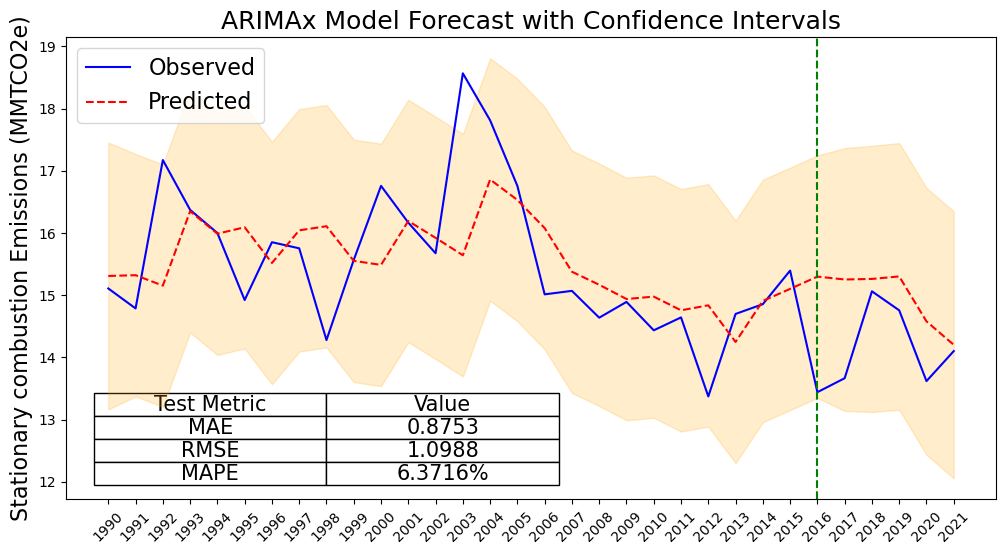

In [11]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([sta_train,sta_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean, test_forecast_df['Stationary combustion']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')



# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([sta_train.index, test_forecast_df.index])

# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

plt.title('ARIMAx Model Forecast with Confidence Intervals', fontsize=18)
#plt.xlabel('Time', fontsize=16)
plt.ylabel('Stationary combustion Emissions (MMTCO2e)', fontsize=16)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.axvline(x=2016, color='green', linestyle='--', label='Year 2016 (X-axis)')

#calculate the error term
# Extract the actual values for the test set
actual_values = df_test['Stationary combustion']

# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['Stationary combustion']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100


# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]

table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.03, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed

plt.savefig('../../../figures/Report-images/arimax-stationary.png', dpi=600, bbox_inches='tight')

In [8]:
import itertools

# Define the range of values for p, d, and q
p_values = range(3)  # Adjust the range based on your preferences
d_values = range(3)
q_values = range(3)

# Initialize a list to store the orders and corresponding AIC and BIC values
order_aic_bic_list = []

# Loop through all combinations of p, d, and q
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit the model for the current combination
        mod = sm.tsa.arima.ARIMA(sta_train, order=(p, d, q), exog=exog2)
        res = mod.fit()

        # Store the order, AIC, and BIC values in the list
        order_aic_bic_list.append(((p, d, q), res.aic, res.bic))

    except Exception as e:
        # Handle any exceptions that might occur during model fitting
        print(f"Issue with order ({p}, {d}, {q}): {e}")

# Sort the list based on AIC values
order_aic_bic_list.sort(key=lambda x: (x[1], x[2]))

# Print the first five best orders and corresponding AIC and BIC values
for i, (order, aic, bic) in enumerate(order_aic_bic_list[:5]):
    print(f"Rank {i + 1} - Order: {order}, AIC: {aic}, BIC: {bic}")


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

Rank 1 - Order: (1, 0, 0), AIC: 80.309304381536, BIC: 85.34169053362193
Rank 2 - Order: (0, 1, 1), AIC: 80.4230124720492, BIC: 84.0796399466538
Rank 3 - Order: (1, 1, 0), AIC: 80.99752423322785, BIC: 84.65415170783245
Rank 4 - Order: (2, 0, 0), AIC: 82.17572625016936, BIC: 88.46620894027677
Rank 5 - Order: (0, 0, 2), AIC: 82.19706108277718, BIC: 88.48754377288459


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model